# Reproduction of Carnegie Research Activity Index Method

## 2018 Rankings

Based on https://carnegieclassifications.iu.edu/pdf/CCIHE2018_Research_Activity_Index_Method.pdf


scikit-learn PCA loadings example found here: https://scentellegher.github.io/machine-learning/2020/01/27/pca-loadings-sklearn.html


In [2]:
import pandas as pd
from sklearn.decomposition import PCA
from  sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()

DATA =  '..\..\Desktop\Carnegie'
# import sklearn

### Import data only using columns required for ranking

The data for the 261 institutions that were included in the analysis within the public file
(http://carnegieclassifications.iu.edu/downloads/CCIHE2018-PublicDataFile.xlsx) specifically, the
columns labeled: S&ER&D, NONS&ER&D, PDNFRSTAFF, FACNUM (used for per capita index calculation),
HUM_RSD, SOCSC_RSD, STEM_RSD, OTHER_RSD. 

In [3]:

columns = ['NAME', 'S&ER&D', 'NONS&ER&D', 'PDNFRSTAFF', 'FACNUM',
'HUM_RSD', 'SOCSC_RSD', 'STEM_RSD', 'OTHER_RSD']
data2018 = pd.read_excel(DATA+'\CCIHE2018-PublicDataFile_Rank_Applied.xlsx', sheet_name='Data',engine='openpyxl', usecols=columns, index_col='NAME')


### Select only the 261 institutions with valid data
The institutions should have values (including 0) for all seven variables. 

In practice I found that only selecting institutions with valid values for S&ER&D gave the correct number (261) institutions. 

In [4]:
data2018 =data2018[(data2018['S&ER&D'] >=0)]
data2018.fillna(value=0, inplace=True)
data2018.shape

(261, 8)

#### Check for UNT

In [5]:
data2018.loc['University of North Texas']

S&ER&D        35443.0
NONS&ER&D      8346.0
PDNFRSTAFF       55.0
FACNUM          767.0
HUM_RSD          62.0
SOCSC_RSD        19.0
STEM_RSD         64.0
OTHER_RSD       123.0
Name: University of North Texas, dtype: float64

**Step 1**: Calculate the three per capita measures by dividing each of the three research measures
(S&ER&D, NONS&ER&D, PDNFRSTAFF) by the number of full-time ladder-rank faculty
(FACNUM).

In [6]:
per_cap_serd = data2018['S&ER&D']/data2018['FACNUM']
per_cap_non_serd = data2018['NONS&ER&D']/data2018['FACNUM']
per_cap_staff = data2018['PDNFRSTAFF']/data2018['FACNUM']

**Step 2**: Convert all ten measures (the 7 raw measures and 3 per capita ones) to ranks from low = 1 to
high = 261 (i.e., ascending order). 

In [7]:
per_cap_serd_rank     = per_cap_serd.rank()
per_cap_non_serd_rank = per_cap_non_serd.rank()
per_cap_staff_rank    = per_cap_staff.rank()

serd_rank      = data2018['S&ER&D'].rank()
non_serd_rank  = data2018['NONS&ER&D'].rank()
staff_rank     = data2018['PDNFRSTAFF'].rank()
hum_rsd_rank   = data2018['HUM_RSD'].rank()
sosc_rsd_rank  = data2018['SOCSC_RSD'].rank()
stem_rsd_rank  = data2018['STEM_RSD'].rank()
other_rsd_rank = data2018['OTHER_RSD'].rank()


**Note**: Carnegie uses the “RANK.AVG” function within Excel, where ties all receive the average value of the group followed by the next available number. For example, the seven numbers 10, 8, 8, 4, 4, 4, 2 would be ranked 7, 5.5, 5.5, 3, 3, 3, 1.

We verify pandas rank() method returns the same values.

In [8]:
test_rank = pd.Series([10, 8, 8, 4, 4, 4, 2]).rank()
print(test_rank)
assert(list(test_rank.values) == [7, 5.5, 5.5, 3, 3, 3, 1])

0    7.0
1    5.5
2    5.5
3    3.0
4    3.0
5    3.0
6    1.0
dtype: float64


**Step 3a**: Calculate the the PCA loadings for the per-capita and aggregated measures. 

In [9]:
RankDF_cap  = pd.DataFrame({
        'per_cap_serd'     : per_cap_serd_rank, 
        'per_cap_non_serd' : per_cap_non_serd_rank,
        'per_cap_staff'    : per_cap_staff_rank})
RankDF_agg = pd.DataFrame({
        'serd'             : serd_rank,
        'non_serd'         : non_serd_rank,
        'staff'            : staff_rank,
        'hum_rsd'          : hum_rsd_rank,
        'sosc_rsd'         : sosc_rsd_rank,
        'stem_rsd'         : stem_rsd_rank,
        'other_rsd'        : other_rsd_rank})

In [10]:

print('Per Capita PCA Loading')
scaler = StandardScaler()
X = scaler.fit_transform(RankDF_cap)
pca = PCA( n_components=0.7, svd_solver='full')
pca.fit(X)

loadings_cap = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_matrix_cap = pd.DataFrame(loadings_cap, columns=['PC1'], index=RankDF_cap.columns)

display(loadings_matrix_cap)


Per Capita PCA Loading


,PC1
per_cap_serd,0.936427
per_cap_non_serd,0.620622
per_cap_staff,0.931934


In [11]:
print('Aggregate PCA Loading')

X = scaler.fit_transform(RankDF_agg)
scaler = StandardScaler()
pca = PCA(n_components=0.7, svd_solver = 'full')
pca.fit(X)

loadings_agg = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_matrix_agg = pd.DataFrame(loadings_agg, columns=['PC1'], index=RankDF_agg.columns)

display(loadings_matrix_agg)

Aggregate PCA Loading


,PC1
serd,0.901014
non_serd,0.818922
staff,0.896128
hum_rsd,0.840900
sosc_rsd,0.866214
stem_rsd,0.910214
other_rsd,0.621869


**Step 3b**: For each institution, calculate the aggregate index score and the per capita index score by
multiplying the appropriate ranks (first seven measures for aggregate; 3 per capita measures for
the per capita index) by the “PCA Coefficients” that are provided in the Research Activity Index
file (http://carnegieclassifications.iu.edu/downloads/CCIHE2018-Research_Activity_Index.xlsx)
and summing the weighted ranks for each index (resulting in two indexes). Make sure to copy
the values from the spreadsheet rather than retyping what appears in the cells (full precision).

For Ref the loadings provided by Carnegie:
**PCA loadings based on rank-order data**
	
| Aggregate analysis (first principal component explained 71% of the total variance)  |                   |
|-------------------------------------------------------------------------------------|-------------------|
| Doctorates:   STEM                                                                  | 0.908688930704778 |
| S&E   R&D Expenditures                                                              | 0.899072420694617 |
| Research   Staff                                                                    | 0.894358620000159 |
| Doctorates:   Social Sciences                                                       | 0.864370115002359 |
| Doctorates:   Humanities                                                            | 0.839135325109965 |
| Non-S&E   R&D Expenditures                                                          | 0.817162007088267 |
| Doctorates:   Other Fields                                                          | 0.621012911597097 |

<br>

| Per-capita analysis (first principal component explained 71% of the total variance) |                   |
| ------------------------------------------------------------------------------------|-------------------|
| Per-capita   S&E R&D Expenditures                                                   | 0.934527          |
| Per-capita   Research Staff                                                         | 0.930298          |
| Per-capita   Non-S&E R&D Expenditures                                               | 0.618853          |


In [12]:
agg_index = pd.Series(data= [0]*len(RankDF_agg), name='agg index', index=RankDF_agg.index)
for col in RankDF_agg.columns:
    loading =  loadings_matrix_agg.loc[col].values[0]
    weighted = RankDF_agg[col] * loading
    agg_index += weighted

display(agg_index.head())

per_cap_index = pd.Series(data= [0]*len(RankDF_cap), name='per-capita index', index=RankDF_cap.index)
for col in RankDF_cap.columns:
    loading =  loadings_matrix_cap.loc[col].values[0]
    weighted = RankDF_cap[col] * loading
    per_cap_index += weighted

display(per_cap_index.head())


NAME
University of Pennsylvania          1451.055808
University of Michigan-Ann Arbor    1474.115474
New York University                 1391.409364
Harvard University                  1480.155116
University of Wisconsin-Madison     1477.085856
Name: agg index, dtype: float64

NAME
University of Pennsylvania          637.797943
University of Michigan-Ann Arbor    566.886700
New York University                 447.600499
Harvard University                  634.678866
University of Wisconsin-Madison     564.382725
Name: per-capita index, dtype: float64

**Step 4**: Create new versions of those two indices by subtracting the minimum value from each score (so
the resulting minimum value is 0).

In [13]:
agg_index = agg_index - min(agg_index)
data2018['agg_index'] = agg_index
per_cap_index = per_cap_index - min(per_cap_index)
data2018['per_cap_index'] = per_cap_index

**Step 5**: For each institution, use the zero adjusted versions of the two index scores created in step 4 to
calculate the distance to the origin (0, 0) of the two index score using the standardized Euclidean
Distance formula (Square root of sum of squared index).


In [14]:
raw_distance = np.sqrt(agg_index**2 + per_cap_index**2)
data2018['raw_distance'] = raw_distance

**Step 6**: Convert the resulting raw distance score to a standardized value but subtracting the overall
mean and dividing by the standard deviation (we used population standard deviation).

In [15]:

stand_distance = (raw_distance - np.mean(raw_distance))/np.std(raw_distance)
data2018['stand_distance'] = stand_distance

### Finally convert to rank

In [16]:
ranking = stand_distance.rank(ascending=False)
data2018['ranking'] = ranking

In [17]:
data2018.sort_values(by='ranking')

,S&ER&D,NONS&ER&D,PDNFRSTAFF,FACNUM,HUM_RSD,SOCSC_RSD,STEM_RSD,OTHER_RSD,agg_index,per_cap_index,raw_distance,stand_distance,ranking
NAME,,,,,,,,,,,,,
Harvard University,1032590.0,90570.0,6962.0,1658.0,143.0,79.0,320.0,176.0,1338.212458,603.232061,1467.890153,1.970566,1.0
University of Pennsylvania,1247686.0,126607.0,1566.0,1613.0,92.0,68.0,251.0,178.0,1309.113149,606.351138,1442.719287,1.906002,2.0
University of Wisconsin-Madison,1105261.0,88152.0,1367.0,3175.0,147.0,86.0,529.0,114.0,1335.143197,532.935920,1437.577146,1.892812,3.0
University of Michigan-Ann Arbor,1434535.0,95604.0,1922.0,4070.0,121.0,79.0,532.0,88.0,1332.172816,535.439895,1435.750776,1.888127,4.0
University of California-Los Angeles,1037780.0,39137.0,2053.0,2982.0,120.0,89.0,420.0,141.0,1322.839193,514.023493,1419.198253,1.845669,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
University of Arkansas at Little Rock,6050.0,783.0,9.0,363.0,0.0,0.0,14.0,12.0,59.229235,46.861499,75.525508,-1.600891,257.0
Tennessee Technological University,11467.0,612.0,3.0,319.0,0.0,0.0,13.0,10.0,48.799098,51.973762,71.292524,-1.611749,258.0
Arkansas State University-Main Campus,7936.0,16.0,1.0,398.0,5.0,0.0,9.0,10.0,63.717821,0.000000,63.717821,-1.631178,259.0


Check for UNT

In [18]:
data2018.loc['University of North Texas']

S&ER&D            35443.000000
NONS&ER&D          8346.000000
PDNFRSTAFF           55.000000
FACNUM              767.000000
HUM_RSD              62.000000
SOCSC_RSD            19.000000
STEM_RSD             64.000000
OTHER_RSD           123.000000
agg_index           723.883045
per_cap_index       195.778183
raw_distance        749.890498
stand_distance        0.128875
ranking             116.000000
Name: University of North Texas, dtype: float64

In [19]:
class Rank():

    def __init__(self, data_dir, data_file):
        columns = ['NAME','S&ER&D', 'NONS&ER&D', 'PDNFRSTAFF', 'FACNUM',
                   'HUM_RSD', 'SOCSC_RSD', 'STEM_RSD', 'OTHER_RSD']
        self.data = pd.read_excel(data_dir+data_file, sheet_name='Data',engine='openpyxl', usecols=columns, index_col='NAME')

        self.data.columns = [c.lower().replace('&','') for c in self.data.columns]

        self.data  =self.data [(self.data ['serd'] >=0)]
        self.data .fillna(value=0, inplace=True)
        # data2018.shape

        self.data = self.apply_activity_index(self.data)

    def apply_activity_index(self, data):
        per_cap_serd = data['serd']/data['facnum']
        per_cap_non_serd = data['nonserd']/data['facnum']
        per_cap_staff = data['pdnfrstaff']/data['facnum']
        
        per_cap_serd_rank     = per_cap_serd.rank()
        per_cap_non_serd_rank = per_cap_non_serd.rank()
        per_cap_staff_rank    = per_cap_staff.rank()

        serd_rank      = data['serd'].rank()
        non_serd_rank  = data['nonserd'].rank()
        staff_rank     = data['pdnfrstaff'].rank()
        hum_rsd_rank   = data['hum_rsd'].rank()
        sosc_rsd_rank  = data['socsc_rsd'].rank()
        stem_rsd_rank  = data['stem_rsd'].rank()
        other_rsd_rank = data['other_rsd'].rank()
            
        RankDF_cap  = pd.DataFrame({
                            'per_cap_serd'     : per_cap_serd_rank, 
                            'per_cap_non_serd' : per_cap_non_serd_rank,
                            'per_cap_staff'    : per_cap_staff_rank})
        RankDF_agg = pd.DataFrame({
                            'serd'             : serd_rank,
                            'non_serd'         : non_serd_rank,
                            'staff'            : staff_rank,
                            'hum_rsd'          : hum_rsd_rank,
                            'sosc_rsd'         : sosc_rsd_rank,
                            'stem_rsd'         : stem_rsd_rank,
                            'other_rsd'        : other_rsd_rank})

 
        scaler = StandardScaler()
        X = scaler.fit_transform(RankDF_cap)
        pca = PCA( n_components=0.7, svd_solver='full')
        pca.fit(X)
        loadings_cap = pca.components_.T * np.sqrt(pca.explained_variance_)
        loadings_matrix_cap = pd.DataFrame(loadings_cap, columns=['PC1'], index=RankDF_cap.columns)

                
        X = scaler.fit_transform(RankDF_agg)
        pca = PCA(n_components=0.7, svd_solver = 'full')
        pca.fit(X)
        loadings_agg = pca.components_.T * np.sqrt(pca.explained_variance_)
        loadings_matrix_agg = pd.DataFrame(loadings_agg, columns=['PC1'], index=RankDF_agg.columns)

        agg_index = pd.Series(data= [0]*len(RankDF_agg), name='agg index', index=RankDF_agg.index)
        for col in RankDF_agg.columns:
            loading =  loadings_matrix_agg.loc[col].values[0]
            weighted = RankDF_agg[col] * loading
            agg_index += weighted

        # display(agg_index.head())

        per_cap_index = pd.Series(data= [0]*len(RankDF_cap), name='per-capita index', index=RankDF_cap.index)
        for col in RankDF_cap.columns:
            loading =  loadings_matrix_cap.loc[col].values[0]
            weighted = RankDF_cap[col] * loading
            per_cap_index += weighted

        # display(per_cap_index.head())

        agg_index = agg_index - min(agg_index)
        data['agg_index'] = agg_index
        per_cap_index = per_cap_index - min(per_cap_index)
        data['per_cap_index'] = per_cap_index

        raw_distance = np.sqrt(agg_index**2 + per_cap_index**2)
        data['raw_distance'] = raw_distance

        
        stand_distance = (raw_distance - np.mean(raw_distance))/np.std(raw_distance)
        data['stand_distance'] = stand_distance

        ranking = stand_distance.rank(ascending=False)
        data['ranking'] = ranking

        return data

    def re_rank(self,name, **kwargs):
        """input institution name and change in one or more measueres in {'serd', 'nonserd', 
           'pdnfrstaff', 'facnum', 'hum_rsd', 'socsc_rsd', 'stem_rsd', 'other_rsd'}"""

        data = self.data.copy()
        print(name)
        for key, value in kwargs.items():
            if key in ['serd', 'nonserd','pdnfrstaff', 'facnum', 'hum_rsd', 'socsc_rsd', 'stem_rsd', 'other_rsd']:
                print('modifying' ,key , 'value')
                data.loc[name][key] = value
            else:
                raise ValueError('not a valid measure')

        return self.apply_activity_index(data)
        

In [20]:
rank = Rank(DATA, data_file ='\CCIHE2018-PublicDataFile_Rank_Applied.xlsx')

In [21]:
display(rank.data.sort_values(by='ranking')[['ranking']])

,ranking
NAME,
Harvard University,1.0
University of Pennsylvania,2.0
University of Wisconsin-Madison,3.0
University of Michigan-Ann Arbor,4.0
University of California-Los Angeles,5.0
...,...
University of Arkansas at Little Rock,257.0
Tennessee Technological University,258.0
Arkansas State University-Main Campus,259.0


In [22]:
rank.data.loc['University of North Texas']

serd              35443.000000
nonserd            8346.000000
pdnfrstaff           55.000000
facnum              767.000000
hum_rsd              62.000000
socsc_rsd            19.000000
stem_rsd             64.000000
other_rsd           123.000000
agg_index           723.883045
per_cap_index       195.778183
raw_distance        749.890498
stand_distance        0.128875
ranking             116.000000
Name: University of North Texas, dtype: float64

In [23]:

new_ranking = rank.re_rank(name='University of North Texas',stem_rsd=100, facnum=800)
print('Old Ranking', rank.data.loc['University of North Texas']['ranking'])
print('New ranking', new_ranking.loc['University of North Texas']['ranking'])


University of North Texas
modifying stem_rsd value
modifying facnum value
Old Ranking 116.0
New ranking 111.0


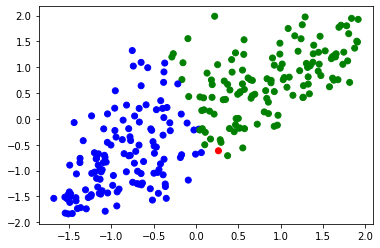

In [36]:
import matplotlib.pyplot as plt

colors =['green' if r <130 else 'blue' for r in rank.data['ranking']]

unt = list(rank.data.index).index('University of North Texas')

colors[unt] = 'red'

plt.scatter(scaler.fit_transform(rank.data['agg_index'].values.reshape(-1,1)),
    scaler.fit_transform(rank.data['per_cap_index'].values.reshape(-1,1)),c=colors)
plt.show()


In [33]:
rank.data['stand_distance']

NAME
University of Pennsylvania                 1.906002
University of Michigan-Ann Arbor           1.888127
New York University                        1.583393
Harvard University                         1.970566
University of Wisconsin-Madison            1.892812
                                             ...   
Rockefeller University                    -0.315973
Yeshiva University                        -0.173187
Southern Illinois University-Carbondale   -0.520207
Ponce Health Sciences University          -1.386791
University of Maryland Eastern Shore      -1.670747
Name: stand_distance, Length: 261, dtype: float64